In [1]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import networkx as nx
import pandas as pd
import functools

from IPython.display import display, Markdown
from dijkstra_algorithm import dijkstra_algorithm

In [2]:
## config
start_node_color = 'green'
end_node_color = 'red' 
standard_node_color = 'white'

#global variables get changed in the following functions
#scale_distances_for_text_pos()
#undo_scale_distances_for_text_pos()
distance_label_node_up = 2.5
distance_label_node_down = 3.1 
distance_label_node_left = 1.5
distance_label_node_right = 1.5
distance_between_labels = 1.5

#Output Definitions
options_original = {
    'font_size': 30,
    'node_size': 3000,
    'with_labels': True,
    'node_color': 'white',
    'edgecolors': 'black',
    'linewidths': 5,
    'width': 5,
    }

options_dijkstra = {
    'font_size': 30,
    'node_size': 3000,
    'with_labels': True,
    'edgecolors': 'black',
    'linewidths': 5,
    'width': 5
    }

edge_label_options = {
    'font_size': 25,
    'font_color': 'black',
    'label_pos': 0.5,
    'rotate': False,
    }

#adjust Setting for Plot
plt.rcParams['figure.figsize']= [12,8] 
plt.rcParams['figure.dpi'] = 60

In [3]:
# observe/on_click functions
def display_uploaded_graph(change, Graph, display_input, display_dijkstra):
    # clear old inputs
    display_input.clear_output()
    display_dijkstra.clear_output()
    Graph.clear()

    # read txt-Data and execute as code, get some values
    start_node, end_node, uploaded_edges, pos = read_uploaded_variables(change)

    # add Edges to Graph
    Graph.add_weighted_edges_from(uploaded_edges)
    # get edge Labels to draw them on plot
    edge_labels = nx.get_edge_attributes(Graph, 'weight')

    # draw Graph on plot
    nx.draw_networkx(Graph, pos, **options_original)
    nx.draw_networkx_edge_labels(Graph, pos, edge_labels=edge_labels, **edge_label_options)

    end_node_slider, start_node_slider = create_start_end_node_sliders(Graph, start_node)

    plt.axis('off')
    with display_input:
        display(Markdown('## Original Network'))
        plt.show()
        display(start_node_slider)
        display(end_node_slider)

    start_node_slider.observe(functools.partial(output_dijkstra, Graph=Graph, 
                                                start_node_slider=start_node_slider,
                                                end_node_slider=end_node_slider, 
                                                display_dijkstra=display_dijkstra,
                                                pos=pos, uploaded_edges=uploaded_edges), 
                              names='value')
    end_node_slider.observe(functools.partial(output_dijkstra, Graph=Graph, 
                                              start_node_slider=start_node_slider,
                                              end_node_slider=end_node_slider, 
                                              display_dijkstra=display_dijkstra,
                                              pos=pos, uploaded_edges=uploaded_edges), 
                            names='value')
    # change value to activate observe
    end_node_slider.value = end_node


def output_dijkstra(change, Graph, start_node_slider, end_node_slider, display_dijkstra, pos, uploaded_edges):
    
    # labels to each node {node : [label0, label1, ...]}
    node_to_labels = {} 
    old_selected_nodes = []

    display_dijkstra.clear_output()

    # dijkstra Algorithm
    node_to_node_to_distance, list_dfs = dijkstra_algorithm(Graph, start_node_slider.value)
    
    # get data for drawing the plots
    color_nodes = define_node_colors(Graph, end_node_slider, start_node_slider)
    edge_labels = nx.get_edge_attributes(Graph, 'weight')

    # draw plot for each node added to path
    for counter, selected_node in enumerate(node_to_node_to_distance):
        # get list of previous selected_ nodes
        old_selected_nodes.append(selected_node)
        
        # draw graph
        nx.draw_networkx(Graph, pos, **options_dijkstra, node_color=color_nodes)
        nx.draw_networkx_edge_labels(Graph, pos, edge_labels=edge_labels, **edge_label_options)

        # scale distances depending on the position scale
        if counter == 0:
            scale_distances_for_text_pos(pos)

        # output of old changes
        draw_old_labels(node_to_labels, old_selected_nodes, pos, selected_node)
        # output new changes
        node_to_labels = draw_new_labels(node_to_node_to_distance, node_to_labels, 
                                             pos, selected_node, start_node_slider.value)

        # at end, reset scaling of text position to original
        if counter == len(node_to_node_to_distance) - 1:
            undo_scale_distances_for_text_pos(pos)

        plt.axis('off')
        with display_dijkstra:
            if counter == 0:
                display(Markdown('## ' + 'Start Graph'))
            else:
                display(Markdown('## ' + str(counter + 1) + '. Iteration'))
                if len(list_dfs[counter - 1] != 0):
                    display(list_dfs[counter - 1].style.hide_index())
            plt.show()

    df_paths = shortest_path_to_all_nodes(Graph, start_node_slider.value, node_to_labels)
    with display_dijkstra:
        display(Markdown('### The shortest path from Node ' + str(start_node_slider.value) + ' to Node ' + str(
            end_node_slider.value) + ' is ' + node_to_labels[end_node_slider.value][-1].split('(')[0] + ' Units long.'))
        display(df_paths.style.hide_index())
    

In [4]:
# functions to shorten code
def read_uploaded_variables(change):
    # read txt-Data and execute as code, get some values
    for key in change['new']:
        string = change['new'][key]['content'].decode('utf-8')
        var_to_value = {}
        exec(string, var_to_value)

        # get variables
        pos = var_to_value['pos']
        uploaded_edges = var_to_value['edges']
        start_node = var_to_value['start_node']
        end_node = var_to_value['end_node']
    return start_node, end_node, uploaded_edges, pos


def create_start_end_node_sliders(Graph, start_node):
    # definiton slider
    start_node_slider = widgets.IntSlider(value=start_node, min=min(Graph.nodes), max=max(Graph.nodes),
                                          description='Startnode:', continuous_update=False)
    # value gets change later to end_node to trigger observe function
    end_node_slider = widgets.IntSlider(value=start_node, min=min(Graph.nodes), max=max(Graph.nodes),
                                        description='Endnode:', continuous_update=False)
    return end_node_slider, start_node_slider


def define_node_colors(Graph, end_node_slider, start_node_slider):
    color_nodes = []
    # define color start and end_node
    for node in Graph.nodes:
        if start_node_slider.value == node:
            color_nodes.append(start_node_color)
        elif end_node_slider.value == node:
            color_nodes.append(end_node_color)
        else:
            color_nodes.append(standard_node_color)
    return color_nodes


def shortest_path_to_all_nodes(Graph, start_node, node_to_labels):
    info_paths = []

    # find shortest path to every node 
    for goal_node in Graph.nodes():
        if goal_node == start_node:
            continue
        else:
            node = goal_node
            # build path in a string 'start_node-node-...-end_node'
            path_text = str(goal_node)
            # while path doesnt't go from start_node to end_nod 
            while node != start_node:

                # get last label of node 
                label = node_to_labels[node][-1]

                # get node and distance from start node to goal node from string
                if node == goal_node:
                    distance = label.split('(')[0]
                # get node, which edge led to our node
                node = int(label.split('(')[1].split(')')[0])

                path_text = str(node) + '-' + path_text

            # save data to the path
            info_paths.append(['Node ' + str(goal_node), distance, path_text])

    end_path_id = 0
    info_paths = sorted(info_paths, key=lambda x: x[end_path_id])
    df_paths = pd.DataFrame(info_paths, columns=['To', 'Distance', 'Path'])
    return df_paths


def get_text_pos(pos, node, number_labels=0):
    x_koord_id = 0
    y_koord_id = 1
    line_x_pos = None
    line_y_pos = None

    min_y_pos, max_y_pos, min_x_pos, max_x_pos = get_outer_coordinates(pos)
    y_middle = min_y_pos + (max_y_pos - min_y_pos) / 2

    # Check if node is on the left or right outer side
    if pos[node][x_koord_id] == min_x_pos or pos[node][x_koord_id] == max_x_pos:

        # y position on same hight as node and distance to the already existing labels
        text_y_pos = pos[node][y_koord_id] + number_labels * distance_between_labels
        line_y_pos = text_y_pos - distance_between_labels

        # adust x Koordinate of label depending on which side the node is
        if pos[node][x_koord_id] == min_x_pos:
            text_alignment = 'right'
            text_x_pos = pos[node][x_koord_id] - distance_label_node_left
        elif pos[node][x_koord_id] == max_x_pos:
            text_x_pos = pos[node][x_koord_id] + distance_label_node_left
            text_alignment = 'left'
    else:
        # x-coordinate is same as node
        text_x_pos = pos[node][x_koord_id]
        text_alignment = 'center'

        # label get positioned below/above node depending on y-coordinate
        # cross out line same position as previous label
        if pos[node][y_koord_id] < y_middle:
            text_y_pos = pos[node][y_koord_id] - distance_label_node_down - number_labels * distance_between_labels
            line_y_pos = text_y_pos + distance_between_labels
        elif pos[node][y_koord_id] >= y_middle:
            text_y_pos = pos[node][y_koord_id] + distance_label_node_up + number_labels * distance_between_labels
            line_y_pos = text_y_pos - distance_between_labels

    # if other labels on node cross the last label out
    if number_labels == None:
        return text_x_pos, text_y_pos, None, None
    else:
        line_x_pos = text_x_pos
        return text_x_pos, text_y_pos, line_y_pos, line_x_pos, text_alignment


# get outer coordinate of all 4 directions
def get_outer_coordinates(pos):
    x_koord_id = 0
    y_koord_id = 1
    min_y_pos = min(pos.values(), key=lambda x: x[y_koord_id])[y_koord_id]
    max_y_pos = max(pos.values(), key=lambda x: x[y_koord_id])[y_koord_id]
    min_x_pos = min(pos.values(), key=lambda x: x[x_koord_id])[x_koord_id]
    max_x_pos = max(pos.values(), key=lambda x: x[x_koord_id])[x_koord_id]
    return min_y_pos, max_y_pos, min_x_pos, max_x_pos


def scale_distances_for_text_pos(pos):
    # change global variables
    global distance_label_node_up
    global distance_label_node_down
    global distance_label_node_left
    global distance_label_node_right
    global distance_between_labels

    standard_axis_length = 20

    # get outer coordinates of all 4 directions
    min_y_pos, max_y_pos, min_x_pos, max_x_pos = get_outer_coordinates(pos)
    # maximal distance in an axis
    x_diff = max_x_pos - min_x_pos
    y_diff = max_y_pos - min_y_pos

    # adjust distance to y-axis
    distance_label_node_up *= y_diff / standard_axis_length
    distance_label_node_down *= y_diff / standard_axis_length
    distance_label_node_left *= x_diff / standard_axis_length
    distance_label_node_right *= x_diff / standard_axis_length
    distance_between_labels *= y_diff / standard_axis_length


def undo_scale_distances_for_text_pos(pos):
    # change global variables
    global distance_label_node_up
    global distance_label_node_down
    global distance_label_node_left
    global distance_label_node_right
    global distance_between_labels

    standard_axis_length = 20

    # get outer coordinates of all 4 directions
    min_y_pos, max_y_pos, min_x_pos, max_x_pos = get_outer_coordinates(pos)
    # max distance in an axis
    x_diff = max_x_pos - min_x_pos
    y_diff = max_y_pos - min_y_pos

    # undo scale
    distance_label_node_up /= y_diff / standard_axis_length
    distance_label_node_down /= y_diff / standard_axis_length
    distance_label_node_left /= x_diff / standard_axis_length
    distance_label_node_right /= x_diff / standard_axis_length
    distance_between_labels /= y_diff / standard_axis_length


def draw_new_labels(node_to_node_to_distance, node_to_labels, pos, selected_node, start_node):
    node_to_labels_copy = node_to_labels.copy()

    # nodes, which get better values from edges that leave selected_node
    for node, distance in node_to_node_to_distance[selected_node].items():
        # label of start_node is different from rest
        label = distance if selected_node == 0 else str(distance) + '(' + str(selected_node) + ')'

        # differentiate first from further labels on node
        if node in node_to_labels:
            number_labels = len(node_to_labels[node])
            node_to_labels_copy[node].append(label)
        elif node not in node_to_labels:
            number_labels = 0
            node_to_labels_copy[node] = [label]

        # draw text on plot
        text_x_pos, text_y_pos, line_y_pos, line_x_pos, text_alignment = get_text_pos(pos, node, number_labels)
        plt.text(text_x_pos, text_y_pos, label, fontsize=20, horizontalalignment=text_alignment,
                 color='orange', bbox=dict(facecolor='white', edgecolor='none'))

        # old text gets crossed out
        if node in node_to_labels:
            plt.text(line_x_pos, line_y_pos, '\u0336'.join((int(len(label) * 1.8) * ' ')) + '\u0336', fontsize=20,
                     horizontalalignment=text_alignment, color='orange')
    return node_to_labels_copy


def draw_old_labels(node_to_labels, old_selected_nodes, pos, selected_node):
    # loop over every label of ever already selected node
    for node_old, labels in node_to_labels.items():
        for label_counter, label in enumerate(labels):
            # check what box color is needed
            if node_old == selected_node and label == labels[-1]:
                box_color = 'orange'
            elif node_old in old_selected_nodes and label == labels[-1]:
                box_color = 'black'
            elif node_old not in old_selected_nodes or label != labels[-1]:
                box_color = 'none'

            # draw text on plot
            text_x_pos, text_y_pos, line_y_pos, line_x_pos, text_alignment = get_text_pos(pos, node_old, label_counter)
            plt.text(text_x_pos, text_y_pos, label, fontsize=20, horizontalalignment=text_alignment, color='black',
                     bbox=dict(facecolor='white', edgecolor=box_color))

            # old text gets crossed out
            if label != labels[0]:
                plt.text(line_x_pos, line_y_pos, '\u0336'.join((int(len(label) * 1.8) * ' ')) + '\u0336', fontsize=20,
                         horizontalalignment=text_alignment)


In [5]:
#Create Widgets on start
display_input = widgets.Output()
display_dijkstra = widgets.Output()
uploader = widgets.FileUpload(accept='.txt', multiple=False )

#create empty Graph
G = nx.Graph()

#Displayed Widgets
display(Markdown('# Dijkstra Algorithm')) 
display(Markdown('Upload your Graph:')) 
display(uploader)
display(display_input)
display(display_dijkstra)

#when Graph uploaded, use Prim Algorithm and Display result
uploader.observe(functools.partial(display_uploaded_graph, 
                                   Graph=G, 
                                   display_input=display_input, 
                                   display_dijkstra=display_dijkstra), 
                 names = 'value')



# Dijkstra Algorithm

Upload your Graph:

FileUpload(value={}, accept='.txt', description='Upload')

Output()

Output()

### Legend

Each label is assigned to a node.



#### label on start node

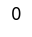

#### label on all other nodes

distance = minimum distance,which was found till now
predecessor_node = node, which arc creates the path with the smallest current distance to the label-node


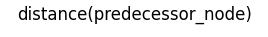

#### temporary label

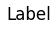

#### new temorary label

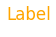

#### permanent Label

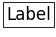

#### new permanent label

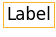

In [6]:
display(Markdown('### Legend'))
print('Each label is assigned to a node.')
print()


# label on start node
fig = plt.gcf()
fig.set_size_inches(1, 1)
plt.text(0.5, 0.5, 0, fontsize=20, horizontalalignment='center', color='black', 
                     bbox=dict(facecolor='white', edgecolor='white'))
plt.tight_layout()
plt.axis('off')
display(Markdown('#### label on start node'))
plt.show()


#label on all other nodes
fig = plt.gcf()
fig.set_size_inches(5, 1)
plt.text(0.5, 0.5, 'distance(predecessor_node)', fontsize=20, horizontalalignment='center', color='black', 
                     bbox=dict(facecolor='white', edgecolor='white'))
plt.tight_layout()
plt.axis('off')
display(Markdown('#### label on all other nodes'))
print('distance = minimum distance,which was found till now')
print('predecessor_node = node, which arc creates the path with the smallest current distance to the label-node')
plt.show()


#temporary label
fig = plt.gcf()
fig.set_size_inches(1, 1)
plt.text(0.5, 0.5, 'Label', fontsize=20, horizontalalignment='center', color='black', 
                     bbox=dict(facecolor='white', edgecolor='white'))
plt.tight_layout()
plt.axis('off')
display(Markdown('#### temporary label'))
plt.show()


#permanent label
fig = plt.gcf()
fig.set_size_inches(1, 1)
plt.text(0.5, 0.5, 'Label', fontsize=20, horizontalalignment='center', color='orange', 
                     bbox=dict(facecolor='white', edgecolor='white'))
plt.tight_layout()
plt.axis('off')
display(Markdown('#### new temorary label'))
plt.show()


#permanent label
fig = plt.gcf()
fig.set_size_inches(1, 1)
plt.text(0.5, 0.5, 'Label', fontsize=20, horizontalalignment='center', color='black', 
                     bbox=dict(facecolor='white', edgecolor='black'))
plt.tight_layout()
plt.axis('off')
display(Markdown('#### permanent Label'))
plt.show()


#new permanent label
fig = plt.gcf()
fig.set_size_inches(1, 1)
plt.text(0.5, 0.5, 'Label', fontsize=20, horizontalalignment='center', color='black', 
                     bbox=dict(facecolor='white', edgecolor='orange'))
plt.tight_layout()
plt.axis('off')
display(Markdown('#### new permanent label'))
plt.show()
